In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint, Bounds
import scipy.special
from scipy.stats import binom, multinomial
from tqdm import tqdm
import functools

from combinations import combinations_

from mpl_toolkits.axes_grid1 import make_axes_locatable


markers = ['o', 'x', 'v', '^', 's', '+', 'D']

In [35]:
def get_configuration_chart(m, kappa):
    '''
    Given the edge states, output all the unique configurations they can be
    in (Balls and bins problem)
    '''
    return np.array(combinations_(kappa, m * 2))

def eta(kappa):
    '''
    Generate a Bernoulli(1/2) distribution on vertices and edges
    '''
    multiplicity = np.fromfunction(lambda _, k: scipy.special.comb(kappa, k), (2, kappa+1))
    eta = multiplicity / (2 ** (kappa+1))
    return eta

def Hamiltonian(beta, kappa):
    '''
    Generate hamiltonian values corresponding to all unique states
    '''
    return np.fromfunction(lambda x0, _: beta * x0, (2, kappa+1))

def relative_entropy(p, q):
    p_divided_by_q = np.divide(p, q, out=np.ones_like(p), where=(p > 0) & (q > 0))
    partial = p * np.log(p_divided_by_q)
    return np.sum(partial)

def edge_distribution(p, kappa):
    '''
    Joint distribution for a randomly-chosen edge 
    '''
    counts = np.vstack((kappa - np.arange(kappa+1),
                        np.arange(kappa+1)))
    return p @ counts.T / kappa

def admissibility_linear(kappa):
    untruncated = np.hstack((-np.arange(kappa+1), kappa - np.arange(kappa+1))) / kappa
    return untruncated[:kappa+2]

def hardcore_linear(kappa):
    return np.eye(2 * (kappa + 1))[list(range(kappa+2, 2*(kappa+1))), :]

def hardcore_rep_to_normal_rep(mu, kappa):
    return np.hstack((mu, np.zeros(kappa))).reshape(2, kappa+1)

def multinomial_coeff(params):
    '''
    Calculate the multinomial coefficient
    
    Inputs:
    params: a list, [x1, x2, ..., xk]
    
    Outputs:
    multinomial coefficient {x1 + x2 + ... + xk \choose x1 x2 ... xk}
    '''
    if len(params) == 1:
        return 1
    return scipy.special.binom(sum(params), params[-1]) * multinomial_coeff(params[:-1])

@functools.cache
def get_multiplicities(kappa):
    # Get the equivalent configuration for each combined vertex-edge state
    def counts(*vertex_marks):
        stacked = np.stack(vertex_marks, axis=0)
        return np.sum(stacked, axis=0)
    ks = np.fromfunction(counts, [2] * kappa, dtype=np.int64)
    
    return ks

def vertex_distribution(p, kappa):
    '''
    Joint distribution for all edge-vertex pairs
    
    Input:
    p: 1-d array representing distribution on leaf configurations
    
    Output:
    kappa-d array representing the joint distribution of all edge-vertex pairs
    '''
    # Match the configurations with the ones from configurations list
    ks = get_multiplicities(kappa)
    k_reshaped = ks.flatten()
    
    # Calculate probabilities for each one
    probabilities = [p[k] / scipy.special.comb(kappa, k) for k in k_reshaped]
    
    return np.array(probabilities).reshape((2,) * kappa)

def objective_function(mu, beta, kappa):
    eta_dist = eta(kappa=kappa)
    hamiltonian = Hamiltonian(beta=beta, kappa=kappa)
    exp = np.sum(hamiltonian * mu)
    rel_entr = relative_entropy(mu, eta_dist)
    
    pi_mu = edge_distribution(mu, kappa=kappa)
    pi_eta = edge_distribution(eta_dist, kappa=kappa)
    marg_rel_entr = relative_entropy(pi_mu, pi_eta)
    return exp - rel_entr + kappa / 2 * marg_rel_entr

def visualize(p, ax, vmin=None, vmax=None):
    '''
    Generates a heatmap for the distribution
    '''
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(p, extent=[0, 2 * p.shape[1], 0, 4], cmap='Greys', vmin=vmin, vmax=vmax)
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            text = ax.text(2*j+1, 4 - (2*i+1), f'{p[i, j]:.3f}',
                        ha="center", va="center", color="red")
    return im

print(f'{eta(kappa=3)=}')
print(f'{Hamiltonian(beta=1, kappa=2)=}')

eta(kappa=3)=array([[0.0625, 0.1875, 0.1875, 0.0625],
       [0.0625, 0.1875, 0.1875, 0.0625]])
Hamiltonian(beta=1, kappa=2)=array([[0., 0., 0.],
       [1., 1., 1.]])


In [3]:
def optimize(beta, kappa, mu0=None, verbose=False, ftol=1e-9, max_iter=1000, project_mu0=False, constraint_tol=0, num_trials=10):
    
    eta_dist = eta(kappa=kappa)
    
    bounds = Bounds(np.zeros(kappa+2), np.ones(kappa+2))
    norm_constraint = LinearConstraint(np.ones(kappa+2), 1-constraint_tol, 1+constraint_tol)
    admissibility_constraint = LinearConstraint(admissibility_linear(kappa=kappa), lb=-constraint_tol, ub=constraint_tol)
    # hardcore_constraint = LinearConstraint(hardcore_linear(kappa=kappa), lb=-constraint_tol, ub=-constraint_tol)

    if verbose:
        print(f'{beta=}, {kappa=}')
    
    if mu0 is None:
        mu0 = np.random.uniform(-1, 1, size=kappa+2)
        mu0 = mu0 / np.sum(mu0)
        # Project onto the closest point on the probability simplex
        if project_mu0:
            res = minimize(lambda mu: np.sum((mu - mu0.flatten())** 2) / 2, x0=mu0.flatten(), 
                        method='trust-constr', 
                        constraints=[norm_constraint, admissibility_constraint], 
                        bounds=bounds)
            # mu0 = res.x.reshape(2, -1)
            if not res.success:
                print('optimization unsuccessfull')
                print(res)
        
    res = minimize(lambda mu: -objective_function(hardcore_rep_to_normal_rep(mu, kappa), beta=beta, kappa=kappa),
                x0=mu0.flatten(), method='SLSQP', 
                constraints=[norm_constraint, admissibility_constraint],
                bounds=bounds,
                options={'ftol': ftol, 'disp': verbose, 'maxiter': max_iter})
    
    if not res.success:
        print('optimization unsuccessfull')
        print(res)
    
    mu = hardcore_rep_to_normal_rep(res.x, kappa)
    objective = objective_function(mu, beta=beta, kappa=kappa)
    
    # if objective > max_objective:
    #     max_objective = objective
    #     max_mu = mu
        
    if verbose:
        print(f'{objective=}\n')
        print(f'mu={mu}\n\n{np.sum(mu)=}\n\n edge_distribution={edge_distribution(mu, kappa=kappa)}')
    
    return mu

beta=1, kappa=3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.01937801356780755
            Iterations: 20
            Function evaluations: 126
            Gradient evaluations: 20
objective=0.01937801356780755

mu=[[0.11428302 0.28125128 0.23072179 0.06308948]
 [0.31065443 0.         0.         0.        ]]

np.sum(mu)=1.0

 edge_distribution=[[0.37869113 0.31065443]
 [0.31065443 0.        ]]


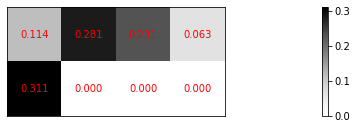

In [136]:
mu = optimize(beta=1, kappa=3, verbose=True, max_iter=1000000, project_mu0=True, ftol=1e-10, num_trials=100)
fig, ax = plt.subplots(1, 1, figsize=(35, 2))
im = visualize(mu, ax)
fig.colorbar(im, ax=ax)
plt.show()

### P(X0, X1)

In [24]:
kappa = 2
beta = 0
mu = optimize(beta, kappa, ftol=1e-10)
edge_distribution(mu, kappa)

array([[0.44721522, 0.27639239],
       [0.27639239, 0.        ]])

In [27]:
kappas = [4, 8, 12, 16, 20, 24, 28]
betas = np.linspace(-5, 5, 31)

res = []
for kappa in kappas:
    mus = []
    for beta in tqdm(betas):
        mu = optimize(beta=beta, kappa=kappa, max_iter=10000, ftol=1e-10)
        mus.append(mu)
        
    res.append(mus)

 16%|█▌        | 5/31 [00:02<00:14,  1.84it/s]

optimization unsuccessfull
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 0.6734220367227302
       x: [ 6.230e-01  2.871e-01 ...  1.873e-14  1.594e-02]
     nit: 103
     jac: [-1.233e+01 -1.438e+01 ...  2.662e+01  4.517e+01]
    nfev: 3419
    njev: 99


 52%|█████▏    | 16/31 [00:12<00:16,  1.13s/it]

optimization unsuccessfull
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 0.5117818066021655
       x: [ 7.790e-02  2.013e-01 ...  8.475e-13  7.790e-02]
     nit: 215
     jac: [-1.249e+01 -1.368e+01 ...  4.405e+00  2.087e+01]
    nfev: 8097
    njev: 211


100%|██████████| 31/31 [00:25<00:00,  1.21it/s]


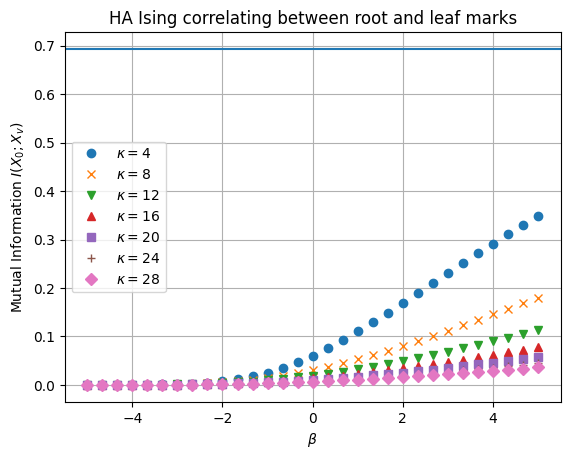

In [28]:
for kappa, mus, m in zip(kappas, res, markers):
    mutual_infos = []
    for mu in mus:
        pi_mu = edge_distribution(mu, kappa)
        p_x0 = np.sum(pi_mu, axis=1)
        p_x1 = np.sum(pi_mu, axis=0)
        mutual_infos.append(relative_entropy(pi_mu, np.outer(p_x0, p_x1)))
    
    plt.plot(betas, mutual_infos, m, label=f'$\\kappa={kappa}$')
    
plt.axhline(y=np.log(2))

plt.legend()
plt.title(f'HA Ising correlating between root and leaf marks')
plt.xlabel('$\\beta$')
plt.ylabel('Mutual Information $I(X_0 ; X_v)$')
plt.grid(True)

# plt.ylim((-.01, 0.11))
plt.savefig('../img/HA_Ising/RL_indep.png')

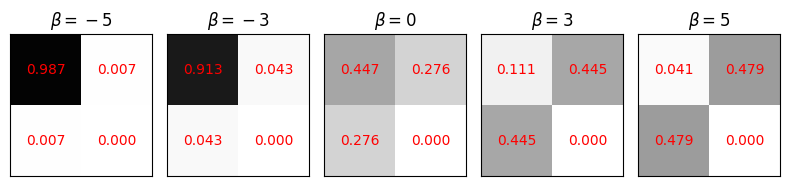

In [61]:
kappa = 2
fig, axes = plt.subplots(1, 5, figsize=(8, 2))
for beta, ax in zip([-5, -3, 0, 3, 5], axes):
    mu = optimize(beta=beta, kappa=kappa, max_iter=10000, ftol=1e-10)
    pi_mu = edge_distribution(mu, kappa)
    im = visualize(pi_mu, ax, vmin=0, vmax=1)
    ax.set_title(f'$\\beta={beta}$')
    
# fig.colorbar(im, ax=axes)
# fig.suptitle('$\pi_\mu$ distribution with different $\\beta$')
fig.tight_layout()
plt.savefig('../img/HA_Ising/RL_indiv')

### P(X1, X2 | X0)

In [141]:
kappa=2
mu = optimize(beta=1, kappa=kappa, verbose=True, max_iter=1000000, project_mu0=True, ftol=1e-10, num_trials=100)

x0 = 0

mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
print(f'{mu_edge=}')
leaf_dist = vertex_distribution(mu_edge, kappa)
leaf_dist = np.sum(leaf_dist, axis=tuple(range(2, kappa)))
print(f'{leaf_dist=}')
p_x1 = np.sum(leaf_dist, axis=1)
p_x2 = np.sum(leaf_dist, axis=0)
print(f'{p_x1=}\n{p_x2=}')
print(f'{np.outer(p_x1, p_x2)=}')

beta=1, kappa=2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.10565207650835434
            Iterations: 13
            Function evaluations: 70
            Gradient evaluations: 13
objective=0.10565207650835434

mu=[[0.13055974 0.3193091  0.19523831]
 [0.35489286 0.         0.        ]]

np.sum(mu)=1.0

 edge_distribution=[[0.29021429 0.35489286]
 [0.35489286 0.        ]]
mu_edge=array([0.20238458, 0.49497064, 0.30264478])
leaf_dist=array([[0.20238458, 0.24748532],
       [0.24748532, 0.30264478]])
p_x1=array([0.4498699, 0.5501301])
p_x2=array([0.4498699, 0.5501301])
np.outer(p_x1, p_x2)=array([[0.20238293, 0.24748697],
       [0.24748697, 0.30264312]])


In [4]:
betas = np.linspace(-3, 3, 31)
kappa = 20

res = []

for beta in tqdm(betas):
    mu = optimize(beta=beta, kappa=kappa, ftol=1e-10)
    res.append(mu)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


In [ ]:
mutual_infos = []
for x0 in [0, 1]:
    mutual_info = []

    for beta, mu in tqdm(zip(betas, res)):
        mu_edge = mu[x0] / np.sum(mu, axis=1)[x0]
        
        leaf_dist = vertex_distribution(mu_edge, kappa=kappa)
        leaf_dist = np.sum(leaf_dist, axis=tuple(range(2, kappa)))
        
        p_x1 = np.sum(leaf_dist, axis=1)
        p_x2 = np.sum(leaf_dist, axis=0)
        indep_dist = np.outer(p_x1, p_x2)

        mutual_info.append(relative_entropy(leaf_dist, indep_dist))
        
    mutual_info = np.array(mutual_info)
    mutual_infos.append(mutual_info)

31it [03:03,  5.93s/it]
31it [02:53,  5.59s/it]


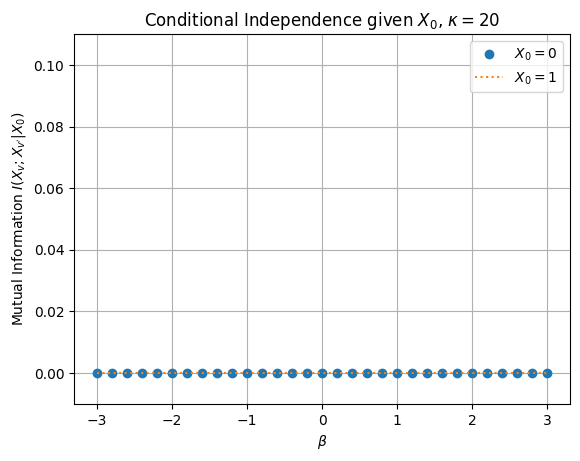

In [5]:
for mutual_info, x0, m in zip(mutual_infos, [0, 1], markers):
    plt.plot(betas, mutual_info, m, label=f'$X_0={x0}$')

plt.legend()
plt.title(f'Conditional Independence given $X_0$, $\kappa={kappa}$')
plt.xlabel('$\\beta$')
plt.ylabel('Mutual Information $I(X_v ; X_{{v\'}} | X_0)$')
plt.grid(True)

plt.ylim((-.01, 0.11))

plt.savefig(f'../img/HA_Ising/CI_kappa{kappa}.png')

### P(X0) with respect to beta

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:16<00:00,  1.84it/s]


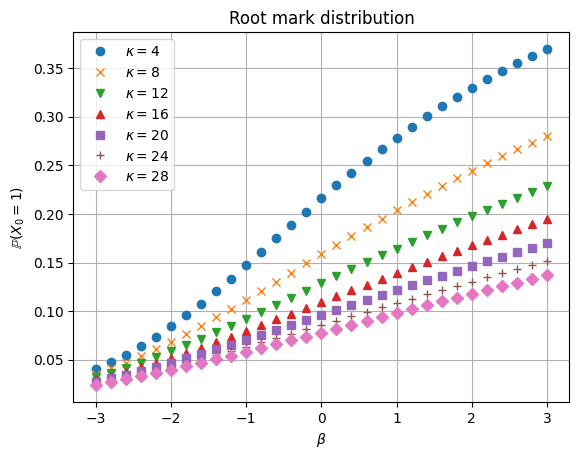

In [14]:
betas = np.linspace(-3, 3, 31)
kappas = [4, 8, 12, 16, 20, 24, 28]

for kappa, m in zip(kappas, markers):
    probabilities = []
    for beta in tqdm(betas):
        mu = optimize(beta=beta, kappa=kappa, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    probabilities = np.array(probabilities)
    plt.plot(betas, probabilities, m, label=f'$\kappa={kappa}$')
plt.title('Root mark distribution')
plt.xlabel('$\\beta$')
plt.ylabel('$\mathbb{P}(X_0=1)$')
plt.grid(True)
plt.legend()
plt.savefig('../img/HA_Ising/RM_raw.png')

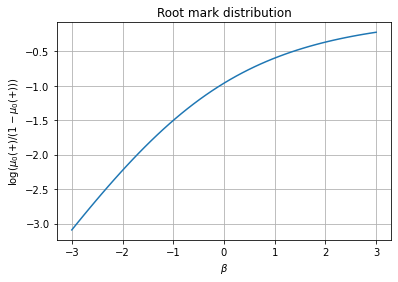

In [168]:
betas = np.linspace(-3, 3, 51)

probabilities = []
for beta in betas:
    mu = optimize(beta=beta, kappa=2, ftol=1e-10)
    probabilities.append(np.sum(mu[1]))
    
probabilities = np.array(probabilities)
    
plt.plot(betas, np.log(probabilities / (1 - probabilities)))
plt.title('Root mark distribution')
plt.xlabel('$\\beta$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)

#### Different $\kappa$ values

In [143]:
kappa = 6
B = 2
C = get_configuration_chart(4, kappa=kappa)
mu = optimize(beta=beta, B=B, kappa=kappa, C=C, ftol=1e-10, verbose=True)

C=array([[0, 0, 0, 6],
       [0, 0, 1, 5],
       [0, 0, 2, 4],
       [0, 0, 3, 3],
       [0, 0, 4, 2],
       [0, 0, 5, 1],
       [0, 0, 6, 0],
       [0, 1, 0, 5],
       [0, 1, 1, 4],
       [0, 1, 2, 3],
       [0, 1, 3, 2],
       [0, 1, 4, 1],
       [0, 1, 5, 0],
       [1, 0, 0, 5],
       [1, 0, 1, 4],
       [1, 0, 2, 3],
       [1, 0, 3, 2],
       [1, 0, 4, 1],
       [1, 0, 5, 0],
       [0, 2, 0, 4],
       [0, 2, 1, 3],
       [0, 2, 2, 2],
       [0, 2, 3, 1],
       [0, 2, 4, 0],
       [1, 1, 0, 4],
       [1, 1, 1, 3],
       [1, 1, 2, 2],
       [1, 1, 3, 1],
       [1, 1, 4, 0],
       [2, 0, 0, 4],
       [2, 0, 1, 3],
       [2, 0, 2, 2],
       [2, 0, 3, 1],
       [2, 0, 4, 0],
       [0, 3, 0, 3],
       [0, 3, 1, 2],
       [0, 3, 2, 1],
       [0, 3, 3, 0],
       [1, 2, 0, 3],
       [1, 2, 1, 2],
       [1, 2, 2, 1],
       [1, 2, 3, 0],
       [2, 1, 0, 3],
       [2, 1, 1, 2],
       [2, 1, 2, 1],
       [2, 1, 3, 0],
       [3, 0, 0, 3],
       [3, 

/Users/yizhonghu/anaconda3/lib/python3.8/site-packages/scipy/optimize/_constraints.py:353: OptimizeWarning: Constraint option `keep_feasible` is ignored by this method.
  warn("Constraint option `keep_feasible` is ignored by this "


Iteration limit reached    (Exit mode 9)
            Current function value: -2.6105165493722495
            Iterations: 100
            Function evaluations: 17347
            Gradient evaluations: 100
objective_function(mu, beta=beta, B=B, kappa=kappa, C=C)=2.6105165493722495

mu=array([[4.30172832e-05, 1.85397466e-07, 2.39811504e-06, 3.19520695e-06,
        6.65701751e-06, 1.28296014e-08, 9.58133810e-09, 1.61135813e-05,
        2.76854463e-05, 6.07518560e-06, 9.16484984e-08, 2.76712122e-07,
        1.60204633e-06, 2.94691440e-06, 8.33536504e-07, 5.93769665e-06,
        1.54181612e-05, 5.57954744e-09, 4.18739704e-09, 1.03412352e-04,
        1.90495315e-04, 9.60875021e-05, 7.19344888e-06, 4.09405332e-06,
        5.55888049e-06, 1.13484307e-06, 1.18294163e-06, 5.88666508e-06,
        4.95041732e-06, 1.76974684e-07, 8.02948746e-07, 3.91883753e-07,
        8.75901297e-09, 4.24539354e-12, 1.00269057e-03, 9.45989248e-04,
        2.73175881e-04, 4.92372454e-05, 3.35471835e-05, 3.48754146e-0

In [139]:
Bs = np.linspace(-2, 2, 31)
kappas = [2, 3, 4, 5, 6]
beta = 1

res = []
for kappa, m in zip(kappas, ['o', ':', 'x', '*', '--']):
    probabilities = []
    for B in tqdm(Bs):
        mu = optimize(beta=beta, B=B, kappa=kappa, ftol=1e-10)
        probabilities.append(np.sum(mu[1]))
        
    res.append(probabilities)

100%|██████████| 31/31 [04:39<00:00,  9.02s/it]


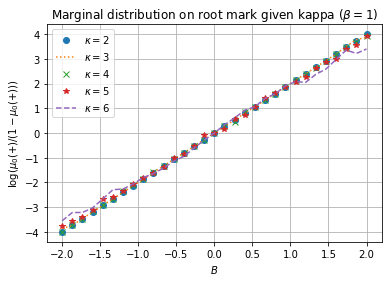

In [146]:
for probabilities, kappa, m in zip(res, kappas, ['o', ':', 'x', '*', '--']):
    probabilities = np.array(probabilities)
    plt.plot(Bs, np.log(probabilities / (1 - probabilities)), m, label=f'$\\kappa={kappa}$')

plt.title(f'Marginal distribution on root mark given kappa ($\\beta={beta}$)')
plt.xlabel('$B$')
plt.ylabel('$\log(\mu_0(+) / (1-\mu_0(+)))$')
plt.grid(True)
plt.legend()
plt.savefig('../img/EA_x0_B_logisitic_change_kappa.png')

In [66]:
A = np.eye(3)
b = np.arange(3)
A + b

array([[1., 1., 2.],
       [0., 2., 2.],
       [0., 1., 3.]])